
**Melaonam Detection | Author: Hariharan | Date: 17 Jan 2022**


**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in **diagnosis**

**Objective**: Create a multiclass classification model using a custom convolutional neural network(CNN) in tensorflow

> Indented block



**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion
 

**Install required libraries**

In [12]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install keras-layer-normalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
!pip install google-colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing all the important libraries

In [15]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Concatenate, LeakyReLU, BatchNormalization, concatenate)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [19]:
##  Mounting the date from google drive: 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Melonama assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [20]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/SkinCancer'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [21]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define few parameters for the loader:

In [22]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [23]:
## Write your train dataset here
## Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [24]:
## Write your validation dataset here
## Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [25]:
## Write your test dataset here
## Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [26]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

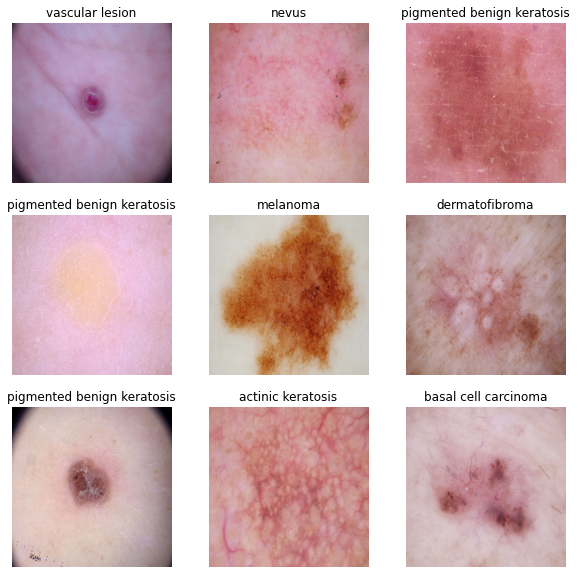

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [29]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [30]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 64)       256       
 ormalization)                                          

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [31]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 64)       256       
 ormalization)                                          

### Train the model

In [33]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 218s 946ms/step - loss: -64477.7930 - accuracy: 0.1713 - val_loss: -62030.5312 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: -770188.3125 - accuracy: 0.1724 - val_loss: -920306.8750 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: -3017595.5000 - accuracy: 0.1724 - val_loss: -2885355.5000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: -7581120.0000 - accuracy: 0.1724 - val_loss: -7620411.5000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: -15164232.0000 - accuracy: 0.1724 - val_loss: -13618987.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: -26711130.0000 - accuracy: 0.1724 - val_loss: -29389004.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - lo

### Visualizing training results

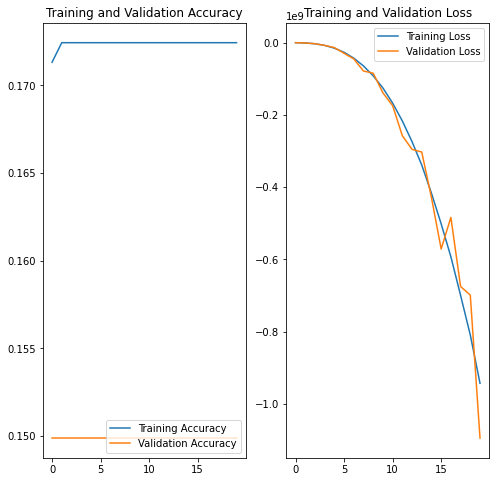

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Overfit or Underfit?

In [35]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 0s 16ms/step - loss: -1094168320.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -1070194560.0
Validation Loss -1094168320.0


In [36]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


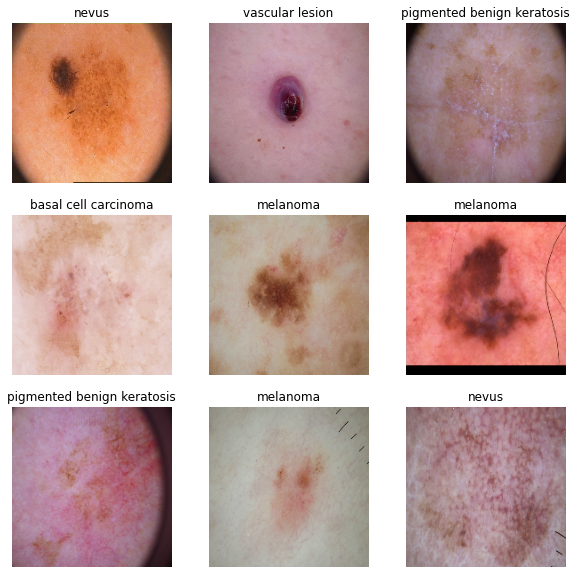

In [37]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Create the model, compile and train the model


In [38]:
## Use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

### Compiling the model

In [39]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [40]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [41]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 52s 4s/step - loss: 254.6432 - accuracy: 0.3820 - val_loss: 2.0706 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 31s 2s/step - loss: 1.3337 - accuracy: 0.4090 - val_loss: 2.0639 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 32s 2s/step - loss: 1.0469 - accuracy: 0.4551 - val_loss: 1.9945 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 1.0357 - accuracy: 0.4708
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 [==============================] - 31s 2s/step - loss: 1.0357 - accuracy: 0.4708 - val_loss: 1.9664 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 31s 2s/step - loss: 0.9900 - accuracy: 0.5146 - val_loss: 2.0083 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 6/20
14/14 [==============================] - 31s 2s/step - loss

### Visualizing the results

<built-in method keys of dict object at 0x7fb69cbda840> :


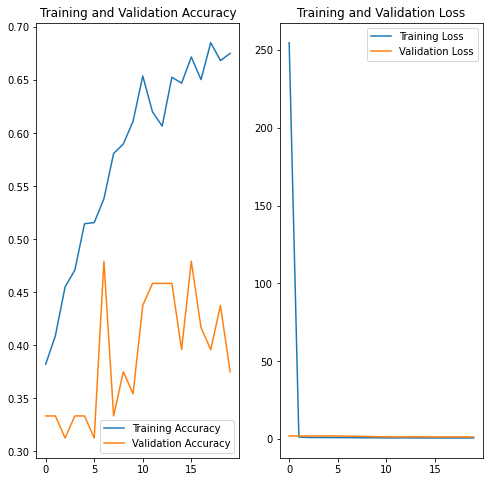

In [42]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
try:
   loss, accuracy = model.evaluate(train_ds, verbose=1,)
   print("Accuracy: ", accuracy)
   print("Loss: ",loss)
except ValueError as ve:
    print(f'error ocurred')

try:
   loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)
   print("Validation Accuracy: ",accuracy_v)
   print("Validation Loss", loss_v)
except ValueError as ve:
    print(f'error ocurred')


error ocurred
error ocurred


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

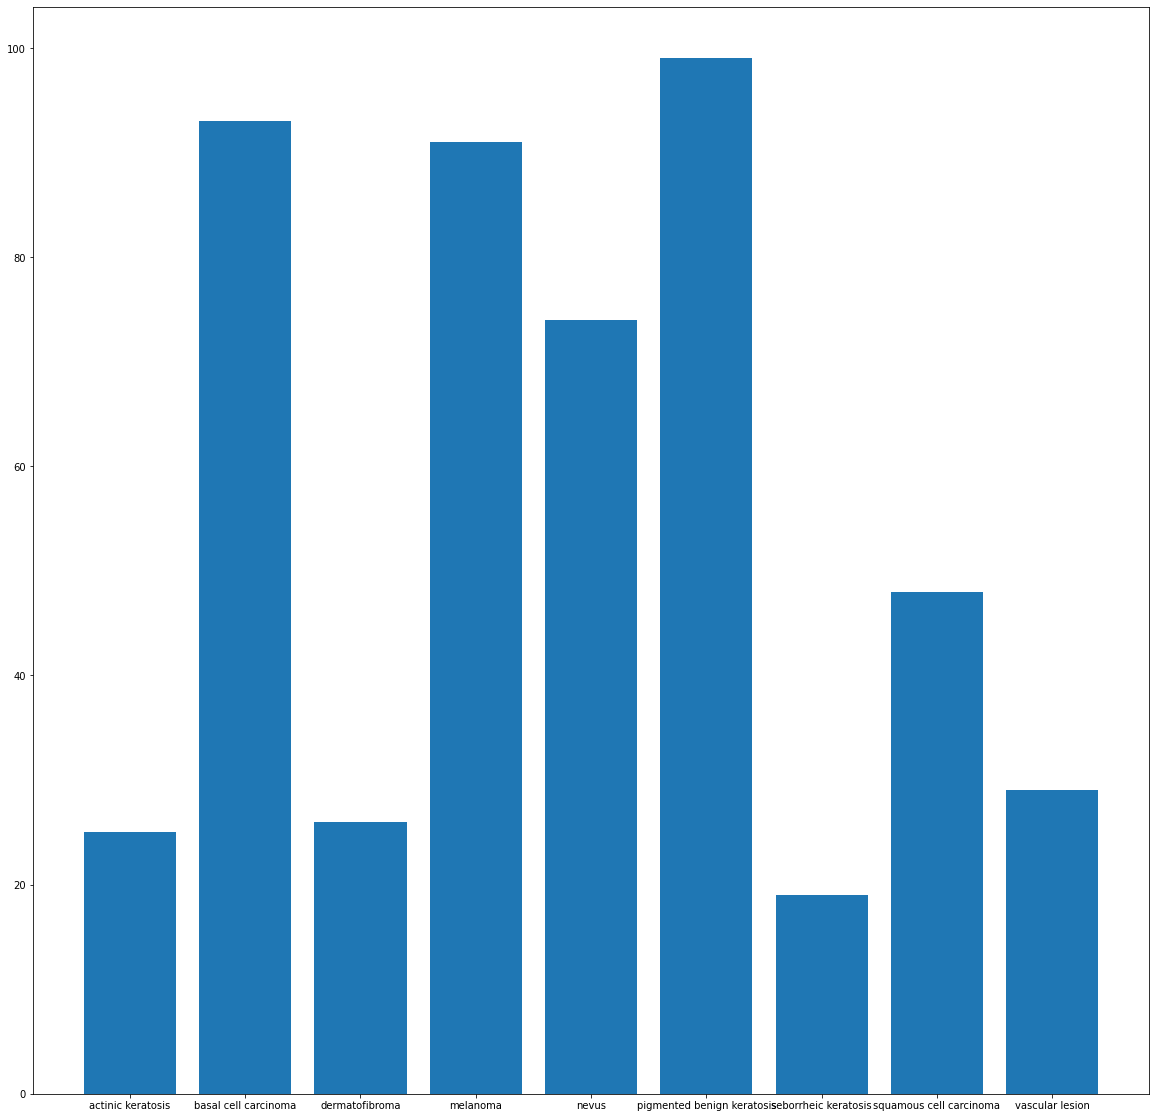

In [53]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### Rectify the class imbalance
#### **Context:** Use a python package known as `Augmentor` to add more samples across all classes so that none of the classes have very few samples.


#### - Which class has the least number of samples? - **Actinic Keratosos** and **Seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
**Pigmented benign keratosis** dominates the data of count more than 100 in training


In [54]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following procedure in general is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [56]:
path_to_training_dataset="/content/gdrive/MyDrive/SkinCancer/Train/"
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB685153430>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB69C6564C0>: 100%|██████████| 500/500 [00:18<00:00, 27.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB703FE72B0>: 100%|██████████| 500/500 [00:18<00:00, 26.81 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2304x1536 at 0x7FB69CE2E340>: 100%|██████████| 500/500 [01:39<00:00,  5.05 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x641 at 0x7FB703FE72B0>: 100%|██████████| 500/500 [01:21<00:00,  6.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB69C9D3A00>: 100%|██████████| 500/500 [00:18<00:00, 27.29 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB7029AA040>: 100%|██████████| 500/500 [00:41<00:00, 12.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB69C65C910>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB703EEB4F0>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [57]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [58]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028370.jpg_405a4eb1-c64a-4064-9d5b-7c51614b3432.jpg',
 '/content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_32303b84-4011-4710-91df-f40b361c9eca.jpg',
 '/content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_479fef27-a445-4dec-bcf8-355049c9484c.jpg',
 '/content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_b136334b-1184-4327-b8c8-fbc12e18d980.jpg',
 '/content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_ce59a311-4785-4adc-926a-acfb8993a59a.jpg',
 '/content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_4de36b99-4fa3-40a5-9ee7-62f623a7c887.jpg',
 '/content/gdrive/MyDrive/SkinCancer/Train/actinic keratosis/output/ac

In [59]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [60]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [61]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [62]:
new_df['Label'].value_counts()

actinic keratosis             500
melanoma                      500
pigmented benign keratosis    500
dermatofibroma                500
seborrheic keratosis          500
vascular lesion               500
squamous cell carcinoma       500
basal cell carcinoma          500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [63]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [64]:
data_dir_train="/content/gdrive/MyDrive/SkinCancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [65]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [67]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)       

#### Compile your model (Choose optimizer and loss function appropriately)

In [68]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

####  Train your model

In [69]:
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
169/169 [==============================] - 42s 230ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 34s 196ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 34s 197ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 4/50
168/169 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1334
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 [==============================] - 34s 196ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 34s 196ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 5.0000e-04
E

####  Visualize the model results

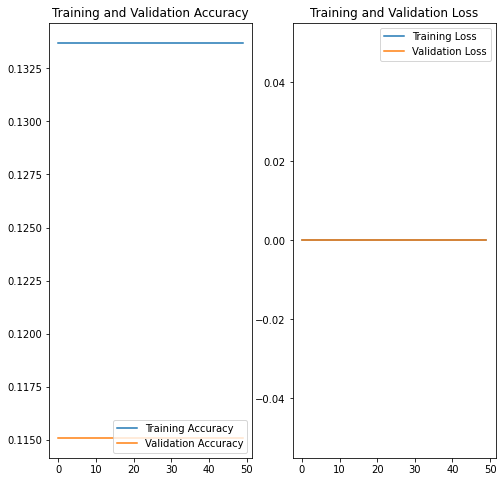

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalance helped in reducing overfititng of the data and thus the loss is beng reduced
But it reduced the Acurracy very low


Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

Then we introduced Dropout and ImageDataGenerator which reduced the over fit

At last, we tried Batch Normalization and Augumentation which really helped in carry forward